In [4]:
import numpy as np
import scipy as sc
import struct
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
%matplotlib inline

### KNNClassifier
Metrics: Cosine Similarity, Euclidean distance

In [28]:
class KNNClassifier:
    
    
    def __init__(self, k=3, metric=None):
        self.k = k
        if metric is None:
            metric = 'euclidean'
        self.metric = metric

    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train

    def predict(self, X_test):
        y_pred = self._cal_predictions(X_test)
        return y_pred

    def _cal_predictions(self, X):
        idx = None
        dist = sc.spatial.distance.cdist(self.X_train, X, metric=self.metric)
        idx = np.argsort(dist, axis=0)[:self.k]
        # pick the most frequently occuring label from top k neighbors 
        k_labels = self.y_train[idx]
        return sc.stats.mode(k_labels, axis=0).mode


In [ ]:
# These functions are not used above as the scipy implementation is far more optimized. 
# But a from-scratch implementation using numpy would look like this:
def cosine_distance(A: np.ndarray, B: np.ndarray) -> np.ndarray: 
    return A.dot(B.T) / (np.linalg.norm(A) * np.linalg.norm(B))

def euclidean_distance(A: np.ndarray, B: np.ndarray) -> np.ndarray: 
    A_s = np.sum(np.square(A), axis=1, keepdims=True)
    B_s = np.sum(np.square(B), axis=1, keepdims=True)
    D = A_s + B_s.T - 2 * A.dot(B.T)
    # numpy precision could lead to negative values in places of zeros
    D[D < 0] = 0
    return np.sqrt(D)

#### Testing on MNIST

In [20]:
# reading mnist byte
# Reference "https://stackoverflow.com/questions/39969045/parsing-yann-lecuns-mnist-idx-file-format"
def read_mnist_idx_images(path):
    with open(path, 'rb') as f:
        magic, size = struct.unpack(">II", f.read(8))
        nrows, ncols = struct.unpack(">II", f.read(8))
        imgs = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
        imgs = imgs.reshape((size, nrows, ncols))
    return imgs


def read_mnist_idx_labels(path):
    with open(path, 'rb') as f:
        magic, size = struct.unpack(">II", f.read(8))
        labels = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
        labels = labels.reshape((size,))
    return labels

In [21]:
mnist_train, mnist_test = dict(), dict()
mnist_train['X'] = read_mnist_idx_images('./data/MNIST/train-images.idx3-ubyte')
mnist_train['y'] = read_mnist_idx_labels('./data/MNIST/train-labels.idx1-ubyte')

mnist_test['X'] = read_mnist_idx_images('./data/MNIST/t10k-images.idx3-ubyte')
mnist_test['y'] = read_mnist_idx_labels('./data/MNIST/t10k-labels.idx1-ubyte')

Plotting a sample from the dataset

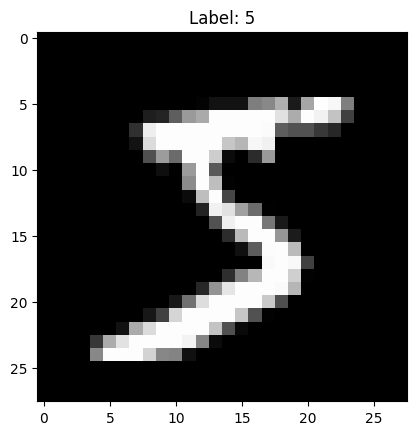

In [22]:
plt.title("Label: " + str(mnist_train['y'][0]))
plt.imshow(mnist_train['X'][0], cmap='gray')
plt.show()

#### Preprocessing

Using a subset of the train and then applying preprocessing to reduce memory usage

In [23]:
mnist_tr_10k_X = mnist_train['X'][:10000]
mnist_tr_10k_y = mnist_train['y'][:10000]

# The test is already 10k
mnist_tr_10k_X = mnist_tr_10k_X.reshape(mnist_tr_10k_X.shape[0], 784)

mnist_ts_X = mnist_test['X'].reshape(mnist_test['X'].shape[0], 784)
mnist_ts_y = mnist_test['y'] 

In [25]:
# We have two normalization options
# Z-score normaliation
def zscore_norm(data: np.ndarray) -> np.ndarray:
    mean = np.mean(data, axis=1).reshape(data.shape[0], 1)
    std = np.std(data, axis=1).reshape(data.shape[0], 1)
    z_normed = (data - mean) / std
    return np.asarray(z_normed, dtype=np.float16)


# Min-max normalization
def min_max_norm(data: np.ndarray) -> np.ndarray:
    norm = data / 255
    return np.asarray(norm, dtype=np.float16)


# 0/1 transformation, sharpens images 
def binary_transform(data: np.ndarray) -> np.ndarray:
    data = min_max_norm(data)
    data[data >= 0.5] = 1
    data[data < 0.5] = 0
    return np.asarray(data, dtype=np.uint8)

In [26]:
mnist_train_norm = zscore_norm(mnist_tr_10k_X)
mnist_test_norm = zscore_norm(mnist_ts_X)

KNN with Euclidean distance

In [18]:
knn = KNNClassifier(k=5, metric='euclidean')
knn.fit(mnist_train_norm, mnist_tr_10k_y)
y_pred = knn.predict(mnist_test_norm)

print(f'Accuracy: {accuracy_score(mnist_ts_y, y_pred)}')

Accuracy: 0.9537


KNN with Cosine distance

In [29]:
knn = KNNClassifier(k=6, metric='cosine')
knn.fit(mnist_train_norm, mnist_tr_10k_y)
y_pred = knn.predict(mnist_test_norm)

print(f'Accuracy: {accuracy_score(mnist_ts_y, y_pred)}')

Accuracy: 0.9532


Let's use 0/1 transformation and compare performance

In [30]:
mnist_tr_binary = binary_transform(mnist_tr_10k_X)
mnist_ts_binary = binary_transform(mnist_ts_X)

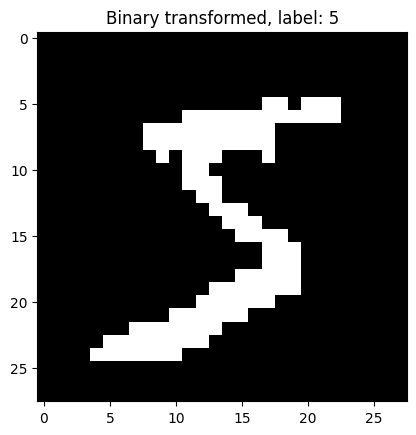

In [34]:
plt.title("Binary transformed, label: " + str(mnist_tr_10k_y[0]))
plt.imshow(mnist_tr_binary[0].reshape(28,28), cmap='gray')
plt.show()

In [31]:
knn = KNNClassifier(k=5, metric='euclidean')
knn.fit(mnist_tr_binary, mnist_tr_10k_y)
y_pred = knn.predict(mnist_ts_binary)
print('Binary transform')
print(f'Accuracy: {accuracy_score(mnist_ts_y, y_pred)}')

Binary transform
Accuracy: 0.9299


We observe a drop in accuracy because of information loss on transforming from [0-225] to {0, 1}